## Experiment 2: Ion Barrier Switching Mode
This experiment determines how the particle beam behaves as the ion barrier goes from active to inactive.

In [1]:
%matplotlib notebook
%load_ext autoreload
%autoreload 2
import libem
import numpy as np
from libvis import Visualizations, VideoMaker
import matplotlib.pyplot as plt

from components import *

from scipy.optimize import root_scalar

**General Configuration**

In [18]:
def generate_barrier_space(V_out=1, V_in=-1, grate_dist=0.5, grate_sp=0.2, th=0.05, scale=30):
    sim = libem.EMSimulationSpace3D(space_size=(4, 2, 2), top_left=(-2, -1, -1), scale=scale)
    sim.compute(make_enforcer(
        enf(EMObjects.planar_mesh_3d, (grate_dist, -0.8, -0.8), 0, (0.1, 1.6, 1.6), (grate_sp, grate_sp), th, V_out),
        enf(EMObjects.planar_mesh_3d, (0, -0.8, -0.8), 0, (0.1, 1.6, 1.6), (grate_sp, grate_sp), th, V_in),
        enf(EMObjects.planar_mesh_3d, (-grate_dist, -0.8, -0.8), 0, (0.1, 1.6, 1.6), (grate_sp, grate_sp), th, V_out),
    ))
    sim.get_efield()
    return sim

NPARTICLES = 10
TIME = 4
THICKNESS = 0.05
DISTANCE = 0.4
SPACING = 0.5
SCALE = 20

particle_opts = {
    "mass": (1, 0.5),
    "charge": (1, 0.5),
    "initial_loc": ((1.9, 0, 0), (0, 0, 0)),
    "initial_v": ((-1, 0, 0), (0.1, 0.1, 0.1)),
    "bounce_coef": 1
}

**Simulate Particle Beam**

<IPython.core.display.Javascript object>


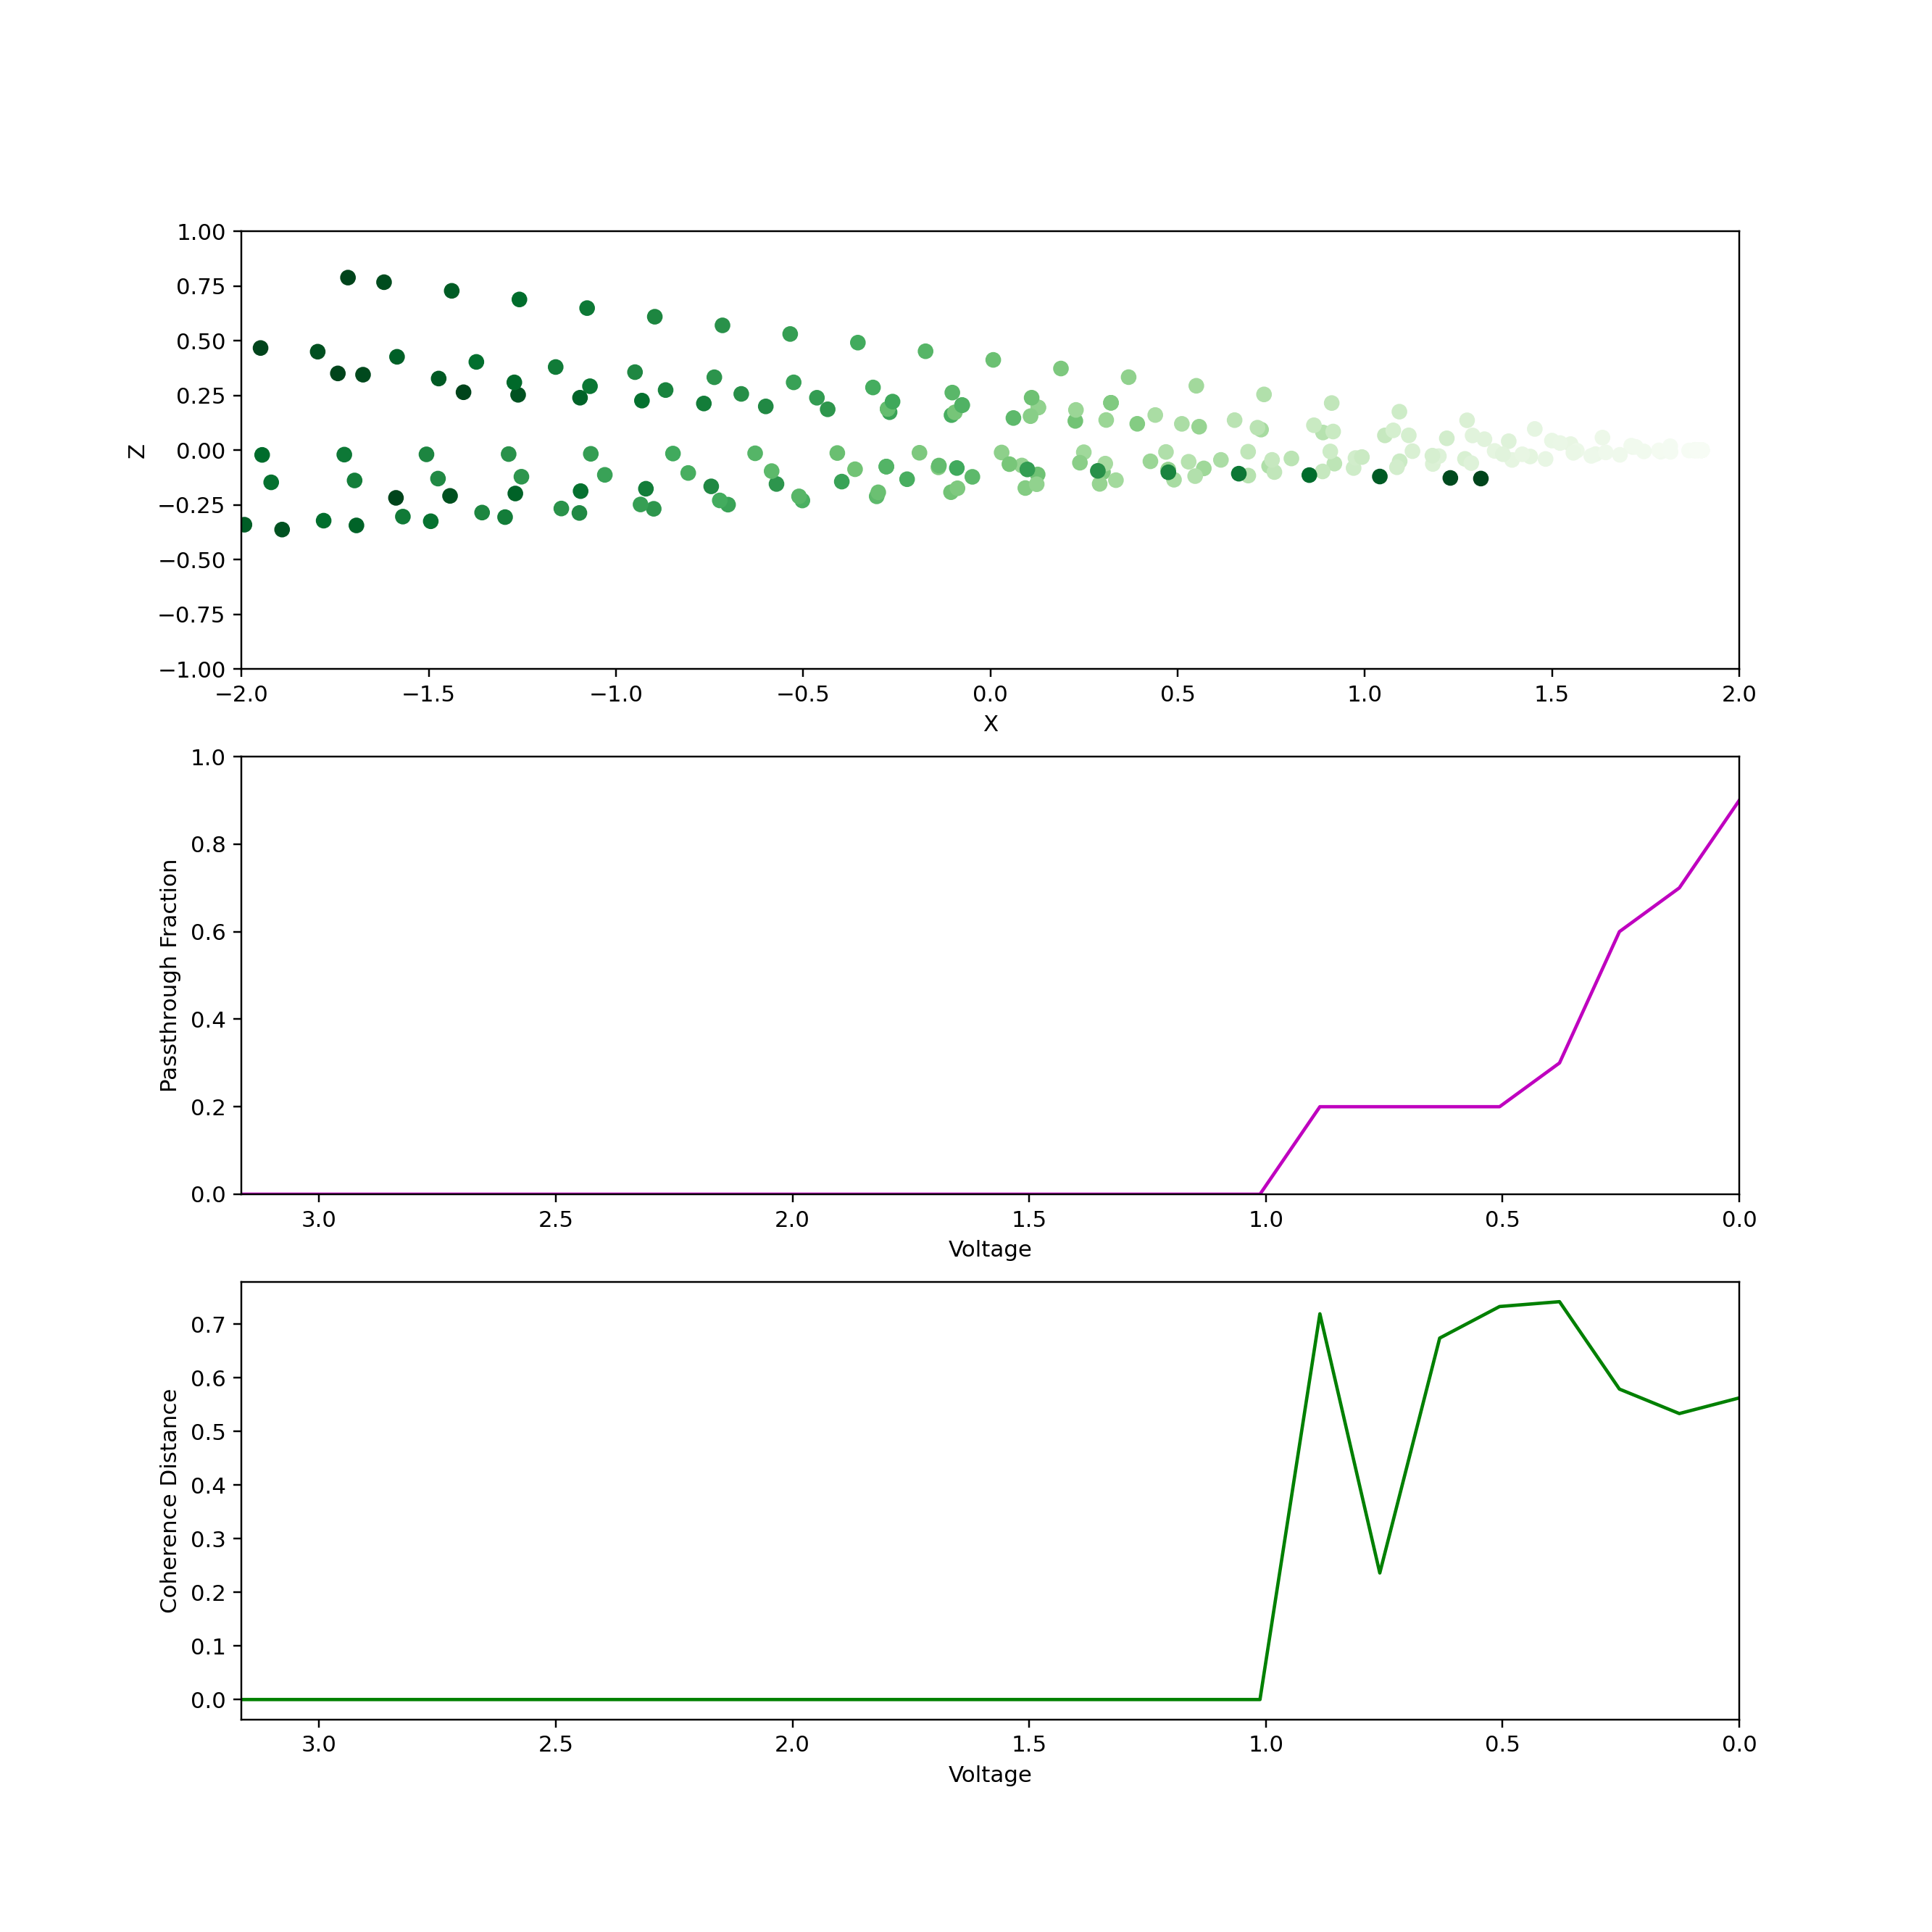

Computing
Voltage 0.0, Particle  100

In [24]:
max_qke = sum(particle_opts["charge"]) * 0.5 * sum(particle_opts["mass"]) * \
            np.linalg.norm(np.array(particle_opts["charge"][0]) + np.array(particle_opts["charge"][1]))**2

voltage_range = np.arange(0, 1.3 * max_qke, 0.05 * max_qke)[::-1]
passthrough = np.zeros(voltage_range.shape)
coherence = np.zeros(voltage_range.shape)

particles = libem.ChargedParticle3D.generate_particles(NPARTICLES, None,
                                                       particle_opts["mass"][0],
                                                       particle_opts["charge"][0],
                                                       particle_opts["initial_loc"][0],
                                                       particle_opts["initial_v"][0],
                                                       particle_opts["mass"][1],
                                                       particle_opts["charge"][1],
                                                       particle_opts["initial_loc"][1],
                                                       particle_opts["initial_v"][1],
                                                       particle_opts["bounce_coef"])

fig, axes = plt.subplots(3, 1, figsize=(12, 12))
plt.show()
video = VideoMaker(fig, axes)

print("Computing")

for i, voltage in enumerate(voltage_range):
    sim = generate_barrier_space(0, voltage, DISTANCE, SPACING, THICKNESS, SCALE)
    
    passed = []
    for j, p in enumerate(particles):
        p.sim = sim
        p.compute_motion((0, TIME))
        if p.position[0][-1] < -DISTANCE:
            passed.append(p.position[:,-1])
        print("\rVoltage " + str(round(voltage, 2)) + ", Particle " + str(j+1).rjust(3), end="")
            
    if len(passed) > 0:
        passed = np.array(passed)
        passthrough[i] = passed.shape[0] / NPARTICLES
        coherence[i] = np.average(np.linalg.norm(passed[:,1:], axis=1))
    
    video.new_frame()
        
    axes[0].set_xlabel("X")
    axes[0].set_ylabel("Z")
    if voltage != 0:
        sim2d = libem.EMSimulationSpace2D.from_3d(sim, axis=1)
        Visualizations.colormesh_2d(sim2d, color_norm=voltage, graph_ax=axes[0])
    for p in particles:
        Visualizations.trajectory_2d(p.time, p.position, axis=1, graph_ax=axes[0])
    axes[0].set_xlim((-2, 2))
    axes[0].set_ylim((-1, 1))
        
    axes[1].set_xlabel("Voltage")
    axes[1].set_ylabel("Passthrough Fraction")
    axes[1].set_xlim((voltage_range[0], voltage_range[-1]))
    axes[1].set_ylim((0, 1))
    axes[1].plot(np.array(voltage_range[:i+1]), np.array(passthrough[:i+1]), color="m")
    
    axes[2].set_xlabel("Voltage")
    axes[2].set_ylabel("Coherence Distance")
    axes[2].set_xlim((voltage_range[0], voltage_range[-1]))
    axes[2].plot(np.array(voltage_range[:i+1]), np.array(coherence[:i+1]), color="g")
        
    video.draw_frame()
    
video.make_movie("beam_passthrough.mp4")